In [2]:
import pandas as pd
import torch
from PIL import Image
from transformers import AutoImageProcessor, ViTForImageClassification
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm  # Untuk progress bar



/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load model dan processor
image_processor = AutoImageProcessor.from_pretrained("chexpert-vit-model/checkpoint-80944")
model = ViTForImageClassification.from_pretrained("chexpert-vit-model/checkpoint-80944")
# model.eval()


In [107]:
labels = list(model.config.id2label.values())
labels

['Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Edema',
 'Consolidation',
 'Atelectasis',
 'Pleural Effusion']

In [5]:
from torch.utils.data import Dataset

label_cols = list(model.config.id2label.values())

label2id = {label: i for i, label in enumerate(label_cols)}
id2label = {i: label for label, i in label2id.items()}

class CheXpertDataset(Dataset):
    def __init__(self, dataframe, transform, label2id):
        # dataframe: list of dict {'Path': ..., 'Labels': [...]}
        self.data = list(dataframe)
        self.transform = transform
        self.label2id = label2id

    def __len__(self):
        # Mengembalikan jumlah data
        return len(self.data)

    def __getitem__(self, idx):
        # Ambil path gambar dan label
        image_path = self.data[idx]['Path']
        findings = self.data[idx]['Labels']
        image = Image.open(image_path).convert("RGB")

        # Membuat vektor biner multilabel
        label_vec = torch.zeros(len(self.label2id))
        for finding in findings:
            if finding in self.label2id:
                label_vec[self.label2id[finding]] = 1.0

        # Transformasi gambar jika ada
        if self.transform:
            image = self.transform(image)

        # Kembalikan dictionary sesuai kebutuhan Trainer HuggingFace
        return {"Path": image, "Labels": label_vec}



In [6]:
def create_label_dataset(df):
    label_columns_temp = df.columns[1:]  # kolom label (kecuali 'Path')
    df2 = []  # list untuk menyimpan data baru
    for idx, row in df.iterrows():
        labels = [col for col in label_columns_temp if row[col] == 1.0]
        df2.append({'Path': row['Path'], 'Labels': labels})

    # Konversi df2 ke DataFrame agar berbentuk tabel
    # df2 = pd.DataFrame(df2, columns=['Path', 'Labels'])
    return df2

df_test = pd.read_csv('df_test.csv')
df_test = create_label_dataset(df_test)

# df_val = pd.read_csv('df_val.csv')
# df_val = create_label_dataset(df_val)

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

dataset_test = CheXpertDataset(df_test, transform, label2id)

## All Test

In [67]:
# Inisialisasi tempat penyimpanan hasil
all_probabilities = []
all_true_labels = []

# Loop melalui semua data test
for idx in tqdm(range(len(df_test)), desc="Processing Test Data"):
    image_test = Image.open(df_test[idx]['Path']).convert("RGB")
    y_actual = dataset_test[idx]['Labels']

    inputs = image_processor(image_test, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits

    probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]

    probabilities = torch.sigmoid(probabilities)

    # Simpan hasil
    all_probabilities.append(probabilities)
    all_true_labels.append(y_actual)

import torch
from torch.nn.functional import sigmoid

# Setelah loop selesai, gabungkan semua tensor 1D menjadi tensor 2D
all_true_labels = torch.stack(all_true_labels)  # Shape: (n_samples, n_labels)
all_probabilities = torch.stack(all_probabilities)  # Shape: (n_samples, n_labels)


Processing Test Data: 100%|██████████| 45/45 [00:03<00:00, 12.27it/s]


In [109]:
auc_acuration = roc_auc_score(all_true_labels, all_probabilities, average=None)
auc_acuration

array([0.33399209, 0.61428571, 0.5       , 0.85142857, 0.585     ,
       0.49747475, 0.73986486])

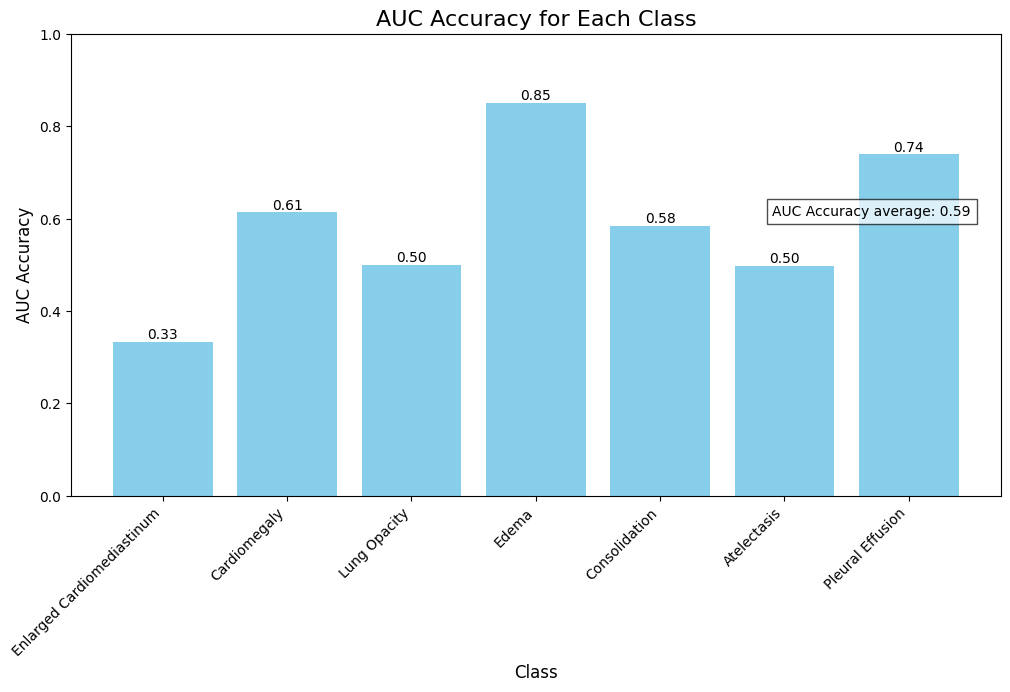

In [125]:
# Membuat plot bar
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, auc_acuration, color='skyblue')

# Menambahkan nilai di atas setiap bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Menambahkan judul dan label
plt.title('AUC Accuracy for Each Class', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('AUC Accuracy', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotasi label x agar lebih mudah dibaca
plt.ylim(0, 1)  # Batas y dari 0 sampai 1 karena AUC range 0-1

plt.text(
    x=6.5, 
    y=0.6, 
    s=f'AUC Accuracy average: {roc_auc_score(all_true_labels, all_probabilities, average="macro"):.2}', 
    ha='right', va='bottom', fontsize=10, 
    bbox=dict(facecolor='white', alpha=0.7)
)

# Menampilkan plot
# plt.tight_layout()
plt.show()

In [97]:
import numpy as np
import torch
from sklearn.metrics import precision_recall_curve, roc_curve

def find_optimal_thresholds(all_true_labels, all_probabilities, id2label):
    """
    Mencari threshold optimal untuk setiap label berdasarkan F1-score maksimal
    dan mengembalikan dalam dua format:
    1. Dictionary berisi nama label dan threshold optimalnya
    2. Array berisi threshold optimal sesuai urutan label index
    
    Args:
        all_true_labels: Tensor 2D (n_samples, n_labels) berisi label benar
        all_probabilities: Tensor 2D (n_samples, n_labels) berisi probabilitas prediksi
        id2label: Dictionary mapping id label ke nama label (dari model.config.id2label)
    
    Returns:
        tuple: (optimal_thresholds_dict, optimal_thresholds_array)
    """
    optimal_thresholds_dict = {}
    n_labels = all_true_labels.shape[1]
    optimal_thresholds_array = np.full(n_labels, np.nan)  # Inisialisasi array dengan NaN
    
    for i in range(n_labels):
        label_name = id2label[i]  # Dapatkan nama label dari id2label
        y_true = all_true_labels[:, i].cpu().numpy()
        y_score = all_probabilities[:, i].cpu().numpy()
        
        # Cek jika label memiliki kedua kelas (0 dan 1)
        if len(np.unique(y_true)) < 2:
            print(f"Label '{label_name}' diabaikan karena hanya memiliki satu kelas.")
            optimal_thresholds_dict[label_name] = np.nan
            optimal_thresholds_array[i] = np.nan
            continue
        
        try:
            # Hitung precision-recall curve
            precision, recall, thresholds = precision_recall_curve(y_true, y_score)
            
            # Hitung F1-score untuk setiap threshold
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
            
            # Ambil threshold dengan F1-score maksimal
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
            
            # Simpan dalam kedua format
            optimal_thresholds_dict[label_name] = optimal_threshold
            optimal_thresholds_array[i] = optimal_threshold
            
            # (Opsional) Hitung AUC untuk referensi
            fpr, tpr, _ = roc_curve(y_true, y_score)
            auc_score = np.trapz(tpr, fpr)
            
            print(f"Label '{label_name}':")
            print(f"  Optimal Threshold = {optimal_threshold:.4f}")
            print(f"  AUC = {auc_score:.4f}")
            print("-" * 50)
            
        except Exception as e:
            print(f"Error pada label '{label_name}': {str(e)}")
            optimal_thresholds_dict[label_name] = np.nan
            optimal_thresholds_array[i] = np.nan
    
    return optimal_thresholds_dict, optimal_thresholds_array

# Contoh Penggunaan
optimal_thresholds_dict, optimal_thresholds_array = find_optimal_thresholds(
    all_true_labels=all_true_labels,
    all_probabilities=all_probabilities,
    id2label=model.config.id2label  # Pastikan model memiliki atribut ini
)

# Hasil akhir dalam format dictionary
print("\nHasil Threshold Optimal (Dictionary):")
for label_name, threshold in optimal_thresholds_dict.items():
    print(f"{label_name}: {threshold:.4f}")

# Hasil dalam format array sesuai urutan index
print("\nHasil Threshold Optimal (Array):")
for i, threshold in enumerate(optimal_thresholds_array):
    print(f"Label index {i}: {threshold:.4f}")

Label 'Enlarged Cardiomediastinum':
  Optimal Threshold = 0.5000
  AUC = 0.3340
--------------------------------------------------
Label 'Cardiomegaly':
  Optimal Threshold = 0.5046
  AUC = 0.6143
--------------------------------------------------
Label 'Lung Opacity':
  Optimal Threshold = 0.5000
  AUC = 0.5000
--------------------------------------------------
Label 'Edema':
  Optimal Threshold = 0.5880
  AUC = 0.8514
--------------------------------------------------
Label 'Consolidation':
  Optimal Threshold = 0.5006
  AUC = 0.5850
--------------------------------------------------
Label 'Atelectasis':
  Optimal Threshold = 0.5007
  AUC = 0.4975
--------------------------------------------------
Label 'Pleural Effusion':
  Optimal Threshold = 0.5610
  AUC = 0.7399
--------------------------------------------------

Hasil Threshold Optimal (Dictionary):
Enlarged Cardiomediastinum: 0.5000
Cardiomegaly: 0.5046
Lung Opacity: 0.5000
Edema: 0.5880
Consolidation: 0.5006
Atelectasis: 0.500

/tmp/ipykernel_1288874/3765400442.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(tpr, fpr)
/tmp/ipykernel_1288874/3765400442.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(tpr, fpr)
/tmp/ipykernel_1288874/3765400442.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(tpr, fpr)
/tmp/ipykernel_1288874/3765400442.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(tpr, fpr)
/tmp/ipykernel_1288874/3765400442.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `s

In [71]:
import numpy as np
import torch
from sklearn.metrics import precision_recall_curve, roc_curve

def find_optimal_thresholds(all_true_labels, all_probabilities, id2label):
    """
    Mencari threshold optimal untuk setiap label berdasarkan F1-score maksimal
    dan menampilkannya dengan nama label.
    
    Args:
        all_true_labels: Tensor 2D (n_samples, n_labels) berisi label benar
        all_probabilities: Tensor 2D (n_samples, n_labels) berisi probabilitas prediksi
        id2label: Dictionary mapping id label ke nama label (dari model.config.id2label)
    
    Returns:
        Dict berisi nama label dan threshold optimalnya
    """
    optimal_thresholds = {}
    n_labels = all_true_labels.shape[1]
    
    for i in range(n_labels):
        label_name = id2label[i]  # Dapatkan nama label dari id2label
        y_true = all_true_labels[:, i].cpu().numpy()
        y_score = all_probabilities[:, i].cpu().numpy()
        
        # Cek jika label memiliki kedua kelas (0 dan 1)
        if len(np.unique(y_true)) < 2:
            print(f"Label '{label_name}' diabaikan karena hanya memiliki satu kelas.")
            optimal_thresholds[label_name] = np.nan
            continue
        
        try:
            # Hitung precision-recall curve
            precision, recall, thresholds = precision_recall_curve(y_true, y_score)
            
            # Hitung F1-score untuk setiap threshold
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
            
            # Ambil threshold dengan F1-score maksimal
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
            
            # Simpan dengan nama label
            optimal_thresholds[label_name] = optimal_threshold
            
            # (Opsional) Hitung AUC untuk referensi
            fpr, tpr, _ = roc_curve(y_true, y_score)
            auc_score = np.trapz(tpr, fpr)
            
            print(f"Label '{label_name}':")
            print(f"  Optimal Threshold = {optimal_threshold:.4f}")
            print(f"  AUC = {auc_score:.4f}")
            print("-" * 50)
            
        except Exception as e:
            print(f"Error pada label '{label_name}': {str(e)}")
            optimal_thresholds[label_name] = np.nan
    
    return optimal_thresholds

# Contoh Penggunaan
optimal_thresholds = find_optimal_thresholds(
    all_true_labels=all_true_labels,
    all_probabilities=all_probabilities,
    id2label=model.config.id2label  # Pastikan model memiliki atribut ini
)

# Hasil akhir dalam format dictionary
print("\nHasil Threshold Optimal:")
for label_name, threshold in optimal_thresholds.items():
    print(f"{label_name}: {threshold:.4f}")

Label 'Enlarged Cardiomediastinum':
  Optimal Threshold = 0.5000
  AUC = 0.3340
--------------------------------------------------
Label 'Cardiomegaly':
  Optimal Threshold = 0.5046
  AUC = 0.6143
--------------------------------------------------
Label 'Lung Opacity':
  Optimal Threshold = 0.5000
  AUC = 0.5000
--------------------------------------------------
Label 'Edema':
  Optimal Threshold = 0.5880
  AUC = 0.8514
--------------------------------------------------
Label 'Consolidation':
  Optimal Threshold = 0.5006
  AUC = 0.5850
--------------------------------------------------
Label 'Atelectasis':
  Optimal Threshold = 0.5007
  AUC = 0.4975
--------------------------------------------------
Label 'Pleural Effusion':
  Optimal Threshold = 0.5610
  AUC = 0.7399
--------------------------------------------------

Hasil Threshold Optimal:
Enlarged Cardiomediastinum: 0.5000
Cardiomegaly: 0.5046
Lung Opacity: 0.5000
Edema: 0.5880
Consolidation: 0.5006
Atelectasis: 0.5007
Pleural Eff

/tmp/ipykernel_1288874/1687781216.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(tpr, fpr)
/tmp/ipykernel_1288874/1687781216.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(tpr, fpr)
/tmp/ipykernel_1288874/1687781216.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(tpr, fpr)
/tmp/ipykernel_1288874/1687781216.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(tpr, fpr)
/tmp/ipykernel_1288874/1687781216.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `s


ANALISIS UNTUK LABEL: ENLARGED CARDIOMEDIASTINUM


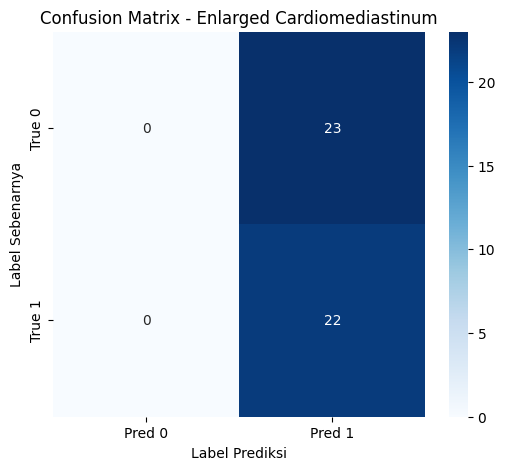

              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        23
     Positif       0.49      1.00      0.66        22

    accuracy                           0.49        45
   macro avg       0.24      0.50      0.33        45
weighted avg       0.24      0.49      0.32        45


ANALISIS UNTUK LABEL: CARDIOMEGALY


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


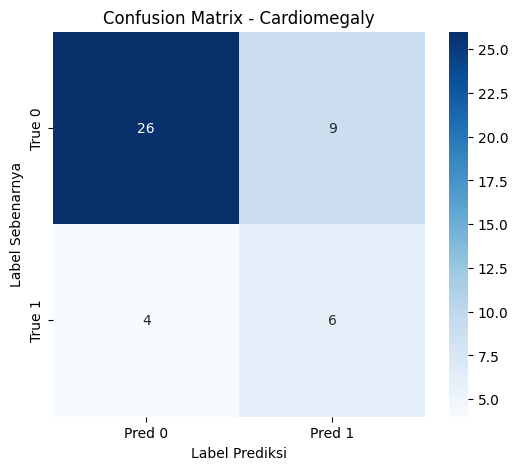

              precision    recall  f1-score   support

     Negatif       0.87      0.74      0.80        35
     Positif       0.40      0.60      0.48        10

    accuracy                           0.71        45
   macro avg       0.63      0.67      0.64        45
weighted avg       0.76      0.71      0.73        45


ANALISIS UNTUK LABEL: LUNG OPACITY


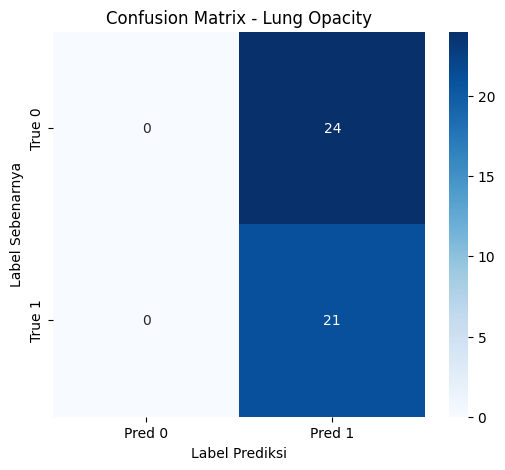

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        24
     Positif       0.47      1.00      0.64        21

    accuracy                           0.47        45
   macro avg       0.23      0.50      0.32        45
weighted avg       0.22      0.47      0.30        45


ANALISIS UNTUK LABEL: EDEMA


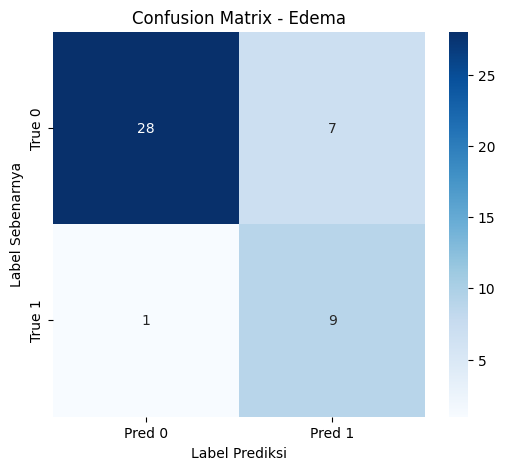

              precision    recall  f1-score   support

     Negatif       0.97      0.80      0.88        35
     Positif       0.56      0.90      0.69        10

    accuracy                           0.82        45
   macro avg       0.76      0.85      0.78        45
weighted avg       0.88      0.82      0.83        45


ANALISIS UNTUK LABEL: CONSOLIDATION


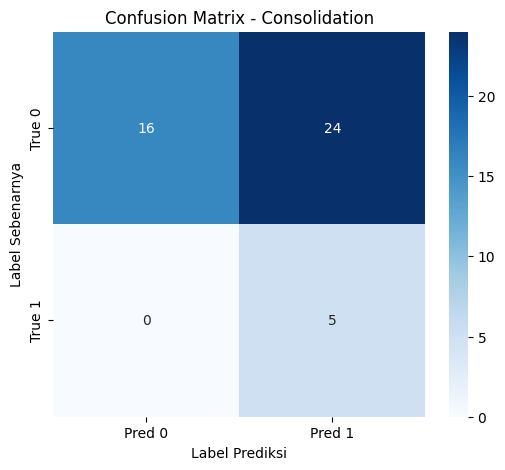

              precision    recall  f1-score   support

     Negatif       1.00      0.40      0.57        40
     Positif       0.17      1.00      0.29         5

    accuracy                           0.47        45
   macro avg       0.59      0.70      0.43        45
weighted avg       0.91      0.47      0.54        45


ANALISIS UNTUK LABEL: ATELECTASIS


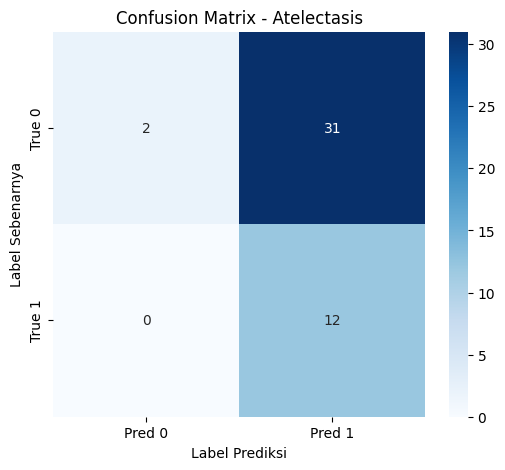

              precision    recall  f1-score   support

     Negatif       1.00      0.06      0.11        33
     Positif       0.28      1.00      0.44        12

    accuracy                           0.31        45
   macro avg       0.64      0.53      0.28        45
weighted avg       0.81      0.31      0.20        45


ANALISIS UNTUK LABEL: PLEURAL EFFUSION


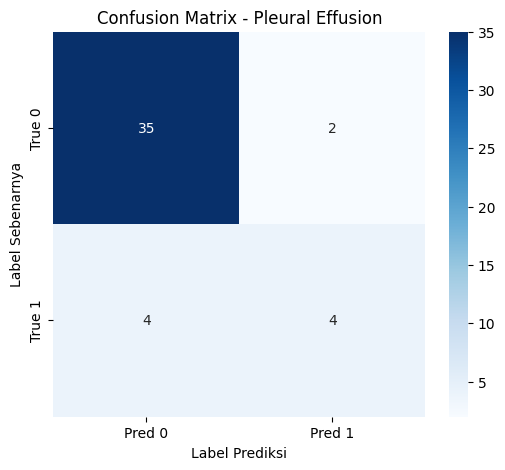

              precision    recall  f1-score   support

     Negatif       0.90      0.95      0.92        37
     Positif       0.67      0.50      0.57         8

    accuracy                           0.87        45
   macro avg       0.78      0.72      0.75        45
weighted avg       0.86      0.87      0.86        45



In [117]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix_per_label(all_true_labels, all_probabilities, id2label, threshold=0.5):
    """
    Membuat confusion matrix dan laporan klasifikasi untuk setiap label.
    
    Args:
        all_true_labels: Tensor 2D (n_samples, n_labels) - label sebenarnya
        all_probabilities: Tensor 2D (n_samples, n_labels) - probabilitas prediksi
        id2label: Dictionary mapping id ke nama label
        threshold: Nilai ambang untuk konversi probabilitas ke prediksi biner
    """
    # Konversi ke numpy array di CPU
    y_true = all_true_labels.cpu().numpy()
    
    n_labels = y_true.shape[1]
    
    for i in range(n_labels):
        y_pred = (all_probabilities.cpu().numpy() >= threshold[i]).astype(int)
    
        label_name = id2label[i]
        print(f"\n{'='*50}")
        print(f"ANALISIS UNTUK LABEL: {label_name.upper()}")
        print(f"{'='*50}")
        
        # Hitung confusion matrix
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        
        # Visualisasi
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Pred 0', 'Pred 1'], 
                    yticklabels=['True 0', 'True 1'])
        plt.title(f'Confusion Matrix - {label_name}')
        # plt.title(f'Confusion Matrix - {label_name}\nThreshold={threshold:.2f}')
        plt.ylabel('Label Sebenarnya')
        plt.xlabel('Label Prediksi')
        plt.show()
        
        # Laporan klasifikasi
        print(classification_report(y_true[:, i], y_pred[:, i], 
                                    target_names=['Negatif', 'Positif']))
        
        # # Hitung metrik tambahan
        # tn, fp, fn, tp = cm.ravel()
        # sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        # specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        # print(f"Detail Metrik:")
        # print(f"- Sensitivity/Recall: {sensitivity:.4f}")
        # print(f"- Specificity: {specificity:.4f}")
        # print(f"- Precision: {tp / (tp + fp):.4f}" if (tp + fp) > 0 else "- Precision: 0")
        # print(f"- F1-Score: {2*tp / (2*tp + fp + fn):.4f}" if (2*tp + fp + fn) > 0 else "- F1-Score: 0")

# Contoh penggunaan
plot_confusion_matrix_per_label(
    all_true_labels=all_true_labels,
    all_probabilities=all_probabilities,
    id2label=model.config.id2label,
    threshold=optimal_thresholds_array
)

## Singel test

logits           :  tensor([[-4.5533, -4.6661,  0.4780, -5.2369,  0.4973,  2.6385,  0.3616]])
probabilities    :  tensor([5.6289e-04, 5.0284e-04, 8.6198e-02, 2.8414e-04, 8.7879e-02, 7.4785e-01,
        7.6727e-02])
y_pred           :  tensor([0.5001, 0.5001, 0.5215, 0.5001, 0.5220, 0.6787, 0.5192])
label_name       :  {0: 'Enlarged Cardiomediastinum', 1: 'Cardiomegaly', 2: 'Lung Opacity', 3: 'Edema', 4: 'Consolidation', 5: 'Atelectasis', 6: 'Pleural Effusion'}
predicted        :  [tensor(True), tensor(False), tensor(True), tensor(False), tensor(True), tensor(True), tensor(False)]
Actual           :  ['Enlarged Cardiomediastinum', 'Lung Opacity', 'Pleural Effusion']


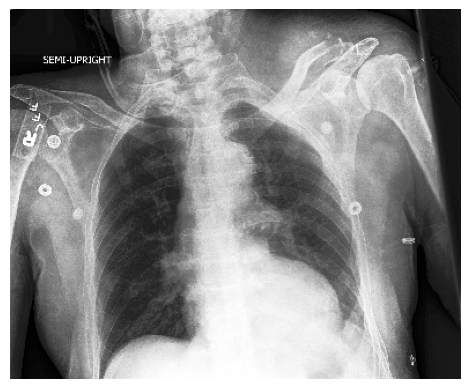


=== HASIL PREDIKSI ===

1. Label Prediksi:
- Enlarged Cardiomediastinum
- Lung Opacity
- Consolidation
- Atelectasis

2. Label Aktual:
- Enlarged Cardiomediastinum
- Lung Opacity
- Pleural Effusion

3. Probabilitas semua label:
- ✓ Enlarged Cardiomediastinum : 0.5001
- ✗ Cardiomegaly               : 0.5001
- ✓ Lung Opacity               : 0.5215
- ✗ Edema                      : 0.5001
- ✓ Consolidation              : 0.5220
- ✓ Atelectasis                : 0.6787
- ✗ Pleural Effusion           : 0.5192


In [116]:
import random
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

# Asumsikan optimal_thresholds_array sudah didefinisikan sebelumnya
# optimal_thresholds_array = [0.6, 0.3, 0.8, ...]  # Contoh threshold per label

random_image = random.randint(0, len(df_test)-1)
image_test = Image.open(df_test[random_image]['Path']).convert("RGB")
labels_actual = df_test[random_image]['Labels']

inputs = image_processor(image_test, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

print("logits           : ", logits)

probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]
y_pred = torch.sigmoid(probabilities)
label_name = model.config.id2label
print("probabilities    : ", probabilities)
print("y_pred           : ", y_pred)
print("label_name       : ", label_name)

# Modifikasi utama di sini: Gunakan optimal_thresholds_array
predicted_label = [y_pred[i] > optimal_thresholds_array[i] for i in range(len(y_pred))]
print("predicted        : ", predicted_label)
print("Actual           : ", labels_actual)

# Tampilkan gambar
plt.imshow(image_test)
plt.axis('off')
plt.show()

# Output setelah plot gambar
print("\n=== HASIL PREDIKSI ===")
# 1. Tampilkan prediksi (label yang diprediksi True)
print("\n1. Label Prediksi:")
predicted_labels = []
for i, is_predicted in enumerate(predicted_label):
    if is_predicted:
        predicted_labels.append(label_name[i])
        # print(f"- {label_name[i]} (Threshold: {optimal_thresholds_array[i]:.4f})")
        print(f"- {label_name[i]}")

if not predicted_labels:
    print("Tidak ada label yang diprediksi True")

# 2. Tampilkan label aktual
print("\n2. Label Aktual:")
if isinstance(labels_actual, list):
    for label in labels_actual:
        print(f"- {label}")
else:
    print(f"- {labels_actual}")

# 3. Tampilkan semua label_name beserta y_pred dan thresholdnya
print("\n3. Probabilitas semua label:")
max_len = max(len(name) for name in label_name.values())  # untuk alignment
for i, name in label_name.items():
    prob = y_pred[i].item()
    threshold = optimal_thresholds_array[i]
    decision = "✓" if prob >= threshold else "✗"
    # print(f"- {decision} {name.ljust(max_len)} : {prob:.4f} (Threshold: {threshold:.4f})")
    print(f"- {decision} {name.ljust(max_len)} : {prob:.4f}")